In [1]:
import numpy as np
import os, sys

# project_root = os.getcwd()
project_root = os.path.abspath("")  # alternative
base_dir = os.path.dirname(project_root)
sys.path.append(os.path.join(base_dir, 'core'))
sys.path.append(os.path.join(base_dir, 'core/utils'))

import torch
from tqdm.auto import tqdm, trange
import matplotlib.pyplot as plt

# Ground truth manifold

[Text(0.5, 1.0, 'Side Projections')]

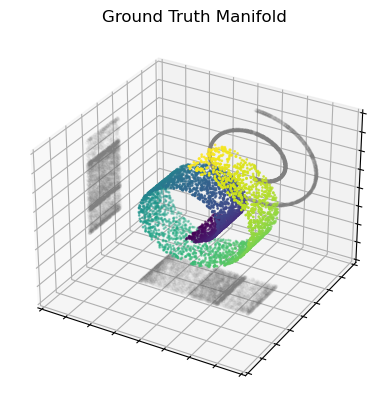

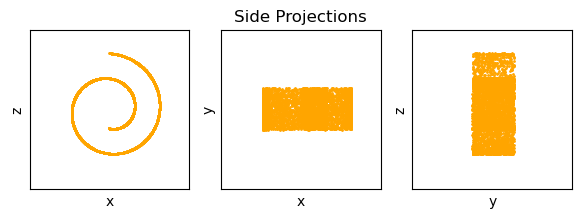

In [2]:
# import dataset
from dataset_utils import load_unimodal_data, load_unimodal_data_3d, load_unimodal_data_nd, make_nd_dataset, generate_2d_swiss_roll
from utils import remove_all_ticks_and_labels

data, colors = make_nd_dataset(int(4e3), 'swiss_roll_3d', noise=0, shrink_y_axis=True, theta=0, return_as_tensor=False)

d0 = data[:, 0]
d1 = data[:, 1]
d2 = data[:, 2]

# --------------------- 3D view of ground truth manifold -------------------- #
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*data[:, 0:3].T, s=1, c=colors)
# ax.set_box_aspect('equal')
# ax.view_init(40, -30, 0)
ax.set_box_aspect(None, zoom=1.0)

lims=[-2, 2]
# ax.set(xlim=lims, ylim=lims, zlim=lims)
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_zlim(-2, 2)

ax.set(title='Ground Truth Manifold')
remove_all_ticks_and_labels(ax, True)

dimx = d0
dimy = d1
dimz = d2

# projections of points on the axes
ax.scatter(dimx, dimy, color='grey', marker='.', linestyle='dashed', alpha=0.03, zdir='z', zs=-2.0)
ax.scatter(dimx, dimz, color='grey', marker='.', linestyle='dashed', alpha=0.03, zdir='y', zs=2.0)
ax.scatter(dimy, dimz, color='grey', marker='.', linestyle='dashed', alpha=0.03, zdir='x', zs=-2.0)


# ------------------------------- side views ------------------------------ #
fig, ax = plt.subplots(1,3, figsize=(7,3))
ax[0].scatter(*data[:, (0,2)].T, s=1, color='orange')
ax[0].set(xlabel='x', ylabel='z')
ax[1].scatter(*data[:, (0,1)].T, s=1, color='orange')
ax[1].set(xlabel='x', ylabel='y')
ax[2].scatter(*data[:, (1,2)].T, s=1, color='orange')
ax[2].set(xlabel='y', ylabel='z')
for a in ax:
    a.set_aspect('equal')
    a.set(xlim=lims, ylim=lims)
    remove_all_ticks_and_labels(a)

ax[1].set(title='Side Projections')


# Neural forward and reverse processes

model loaded!


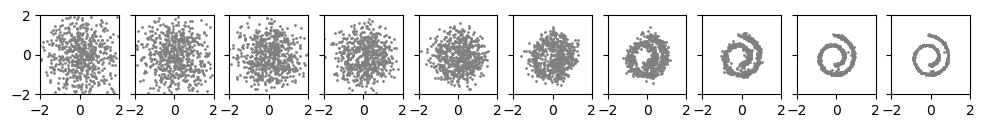

In [3]:
# ---------- load model details and load model with trained weights ---------- #
from utils import select_model
model, num_steps, embedding_dims = select_model('unconditional-dendritic', 47)


# -------------------- plot reverse samples from the model ------------------- #
from prior_utils import plot_reverse_samples_10_steps
num_samples = int(1e2)
alphas, betas, one_minus_alphas_prod_sqrt, x_seq, _, _ = plot_reverse_samples_10_steps(model, num_samples, embedding_dims, num_steps, normalized_beta_schedule=True)

In [11]:
# --------------- sample from the prior using neural forward and reverse processes -------------- #
from prior_utils import sequential_prior_sampler

gt_manifold = generate_2d_swiss_roll(int(1e3), True)[1]
init_x = gt_manifold[0].reshape(-1, 2)
seq_x, seq_fwd_x, seq_rev_x = sequential_prior_sampler(model, init_x, num_cycles=int(5e2), normalized_beta_schedule=True)

  0%|          | 0/500 [00:00<?, ?it/s]

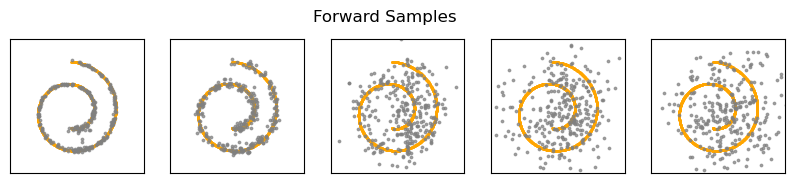

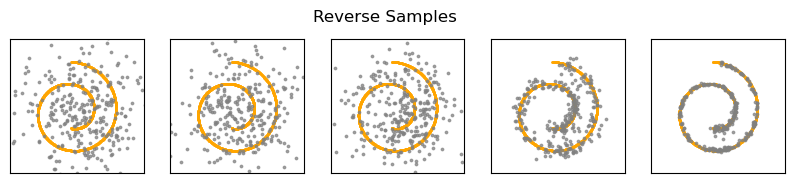

In [19]:
# intermediate steps during the forward/reverse processes
temps = [0, 25, 50, 75, 100]
lim = 1.5
lims = [-lim, lim]

fig, ax = plt.subplots(1, len(temps), figsize=(10,2))
fig.suptitle('Forward Samples')
for i, t in enumerate(temps):
    ax[i].scatter(*gt_manifold.T, s=1, color='orange')
    ax[i].scatter(*seq_fwd_x[:300,t].T, s=3, alpha=0.7, color='grey')
    
for a in ax:
    a.set_aspect('equal')
    a.set(xlim=lims, ylim=lims)
    remove_all_ticks_and_labels(a)
    

fig, ax = plt.subplots(1, len(temps), figsize=(10,2))
fig.suptitle('Reverse Samples')
for i, t in enumerate(temps):
    ax[i].scatter(*gt_manifold.T, s=1, color='orange')
    ax[i].scatter(*seq_rev_x[200:500,t].T, s=3, alpha=0.7, color='grey')

for a in ax:
    a.set_aspect('equal')
    a.set(xlim=lims, ylim=lims)
    remove_all_ticks_and_labels(a)

# autocorrelation of prior samples 

as compared against samples generated by diffusion models

In [95]:
# load samples generated by the neural (sequential sampling) model and the diffusion (iid samples) model
import zarr
data_dir_ac = os.path.join(base_dir, 'core/saved_arrays/autocorrelation')
samples_seq = zarr.load(os.path.join(data_dir_ac, 'seq_prior_samples_runs=4000_cycles=50.zarr'))
samples_iid = zarr.load(os.path.join(data_dir_ac, 'iid_prior_samples_runs=4000_cycles=50.zarr'))

[Text(0.5, 1.0, 'Difference in AC between sequential and iid sampling')]

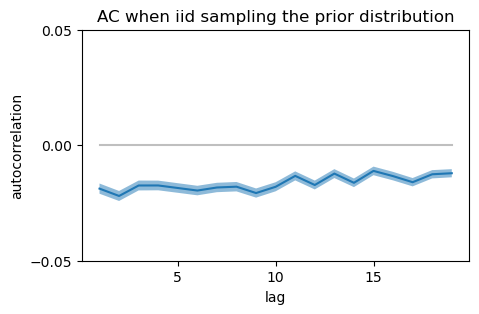

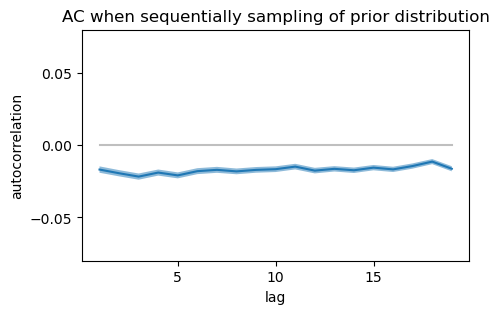

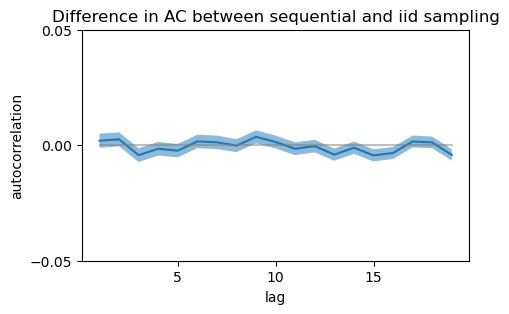

In [99]:
num_runs = 4000
num_cycles = 50
num_lags_to_plot = 20
x_linspace = range(1, num_lags_to_plot)

# iid samples
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
mean_iid = samples_iid.mean(axis=0)[1:num_lags_to_plot]
ax.plot(x_linspace, mean_iid)
error_iid = samples_iid.std(axis=0)[1:num_lags_to_plot] / np.sqrt(num_runs)
ax.fill_between(x_linspace, mean_iid-error_iid, mean_iid+error_iid, alpha=0.5)
ax.set(xlabel='lag', ylabel='autocorrelation')
ax.set(title='AC when iid sampling the prior distribution')
ax.set(ylim=[-.05, .05])
ax.plot(x_linspace, np.zeros_like(x_linspace), c='grey', alpha=0.5)
ax.set_yticks([-0.05, 0, 0.05])
ax.set_xticks(range(5, num_lags_to_plot+1, 5)[:-1])

# sequential sampling
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
mean_seq = samples_seq.mean(axis=0)[1:num_lags_to_plot]
ax.plot(x_linspace, mean_seq)
error_seq = samples_seq.std(axis=0)[1:num_lags_to_plot] / np.sqrt(num_runs)
ax.fill_between(x_linspace, (mean_seq-error_seq), (mean_seq+error_seq), alpha=0.5)
ax.set(xlabel='lag', ylabel='autocorrelation')
ax.set(title='AC when sequentially sampling of prior distribution')
ax.set(ylim=[-.08, .08])
ax.plot(x_linspace, np.zeros_like(x_linspace), c='grey', alpha=0.5)
ax.set_yticks([-0.05, 0, 0.05])
ax.set_xticks(range(5, num_lags_to_plot+1, 5)[:-1])

# comparison
ac_swiss_roll_prior_diff = samples_seq - samples_iid
mean_diff = ac_swiss_roll_prior_diff.mean(axis=0)[1:num_lags_to_plot]
std_diff = ac_swiss_roll_prior_diff.std(axis=0)[1:num_lags_to_plot] / np.sqrt(num_runs)

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(x_linspace, mean_diff)
ax.fill_between(x_linspace, mean_diff-std_diff, mean_diff+std_diff, alpha=0.5)
ax.plot(x_linspace, np.zeros_like(x_linspace), c='grey', alpha=0.5)
ax.set(xlabel='lag', ylabel='autocorrelation')
ax.set_xticks(range(5, num_lags_to_plot+1, 5)[:-1])
ax.set_yticks([-0.05, 0, 0.05])
ax.set(title='Difference in AC between sequential and iid sampling')

# samples are distributed like the ground truth manifold

We measure whether the samples generated by our model are distributed in the same manner as our ground truth manifold using the Kolmogorov-Smirnov test, which answers the question, "How likely is it that we would see a collection of samples like this if they were drawn from that probability distribution?"

For the KS test, we need a 1D null/reference distribution and samples from your empirical distribution. It then quantifies a distance between the empirical distribution function of the sample and the cumulative distribution function of the reference distribution. 

The 2D swiss roll is generated by a single latent variable $t$ using the following equation:

$$v = 1.5 \pi (1 + 2t)\\
x = v \cos(v) / 10\\
y = v \sin(v) / 10\\
$$

where $x$ and $y$ denote the x and y coordinates of the manifold data points. The ground truth manifold is uniformly distributed in this $t$ space. 

We can compute how the 1D empirical distribution by projecting the generated samples onto the ground truth manifold (minimizing Euclidean distance) and calculating the corresponding values of $t$. 

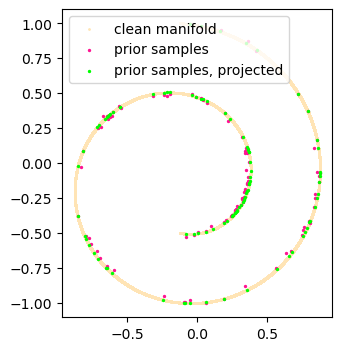

In [143]:
# prior sampled manifold
number_of_samples = int(1000)

# load sequentially sampled prior data 
data_dir_ks = os.path.join(base_dir, 'core/saved_arrays/ks_test')
prior_samples = zarr.load(os.path.join(data_dir_ks, 'prior_samples_1e5.zarr'))
prior_samples = prior_samples[:number_of_samples, :]

# clean ground truth manifold samples
from dataset_utils import generate_2d_swiss_roll
clean_manifold_num_samples = int(5e4)  # supersampled manifold
clean_manifold_t, clean_manifold, min, max = generate_2d_swiss_roll(clean_manifold_num_samples, rescaled=True)

# project onto clean manifold
from analysis_utils import project_onto_clean_2d_roll_manifold
rad_points_xy, rad_points_t = project_onto_clean_2d_roll_manifold(prior_samples, clean_manifold, min, max, clean_manifold_t)

# plot
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.scatter(*clean_manifold.T, s=1, c='moccasin', alpha=1, label='clean manifold')
ax.scatter(*prior_samples[:100].T, s=2, c='deeppink', label='prior samples')
ax.scatter(*rad_points_xy[:100].T, s=2, c='lime', label='prior samples, projected')
ax.legend(loc='upper left')
ax.set_aspect('equal')


ks statistic: 0.03604182083641672
p_value, uniform dist: 0.14522567167484324


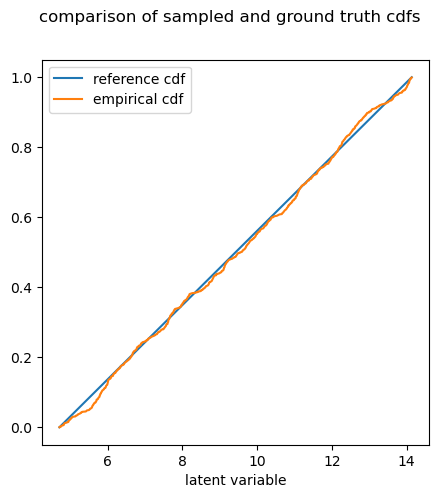

In [144]:
# ---------------- comparison of empirical and reference cdfs ---------------- #
fig, ax = plt.subplots(1, 1, figsize=(5, 5), sharey=True)
fig.suptitle('comparison of sampled and ground truth cdfs')

# reference cdf
import scipy.stats as stats
reference_dist_cdf = stats.uniform.cdf(clean_manifold_t, loc=1.5 * np.pi, scale=3 * np.pi)

# plotting the empirical cdf against the reference cdf
# reference cdf (uniform distribution)
ax.plot(clean_manifold_t, reference_dist_cdf, label='reference cdf')

# empirical cdf for rad
empirical_samples_rad = rad_points_t[:, 0]
x_rad = np.sort(empirical_samples_rad)
y_rad = np.arange(len(x_rad))/float(len(x_rad))
ax.plot(x_rad, y_rad, label='empirical cdf')
ax.set(xlabel='latent variable')
ax.legend()

# ---------------------------------- KS test --------------------------------- #
# two sided ks test between rad and vanilla models
statistic, p_value = stats.kstest(empirical_samples_rad, 'uniform', args=(1.5 * np.pi, 3 * np.pi))
print('ks statistic:', statistic)
print('p_value, uniform dist:', p_value)

If the p-value is higher than our threshold of 0.05, we accept the null hypothesis instead of the default "two-sided" alternative, i.e. the data *are* distributed according to the uniform distribution. In this cas, we see that the p value is 0.145 > 0.05, meaning that we can accept our hypothesis that the data comes from a uniform distribution. 